## 로지스틱 회귀(Logistic Regression)
#### 럭키백의 확률

러키백에 어떤 종류의 생선이 있는지 확률을 구하려 한다.

생선의 종류는 총 7개이고, 알고있는 생선의 특성은 길이, 높이, 두께, 대각선의 길이, 무게이다. 이 특성 데이터를 가지고 러키백에 담긴 생선이 어떤 종류인지 예측해야 한다.

classification을 위해 처음 사용해봤던 kNN 알고리즘 (k-최근접 이웃 알고리즘)으로 예측을 시도해보았다. 예측하려는 샘플의 가까운 이웃의 클래스 비율을 확률로 출력하고 샘플 생선의 종류를 예측할 수 있다.

만약 가까운 이웃 10개의 클래스들이 각각 다음과 같다면:

- 종류A: 2개, 종류B: 7개, 종류C: 1개
- 예측 하려는 샘플의 종류는: 종류A: 20%, 종류B: 70%, 종류C: 10%의 확률을 갖고있다.

### 데이터 준비

In [1]:
import pandas as pd

fish=pd.read_csv('data/fish.csv')
print(fish.info())
fish.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB
None


,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [2]:
# 어떤 종류의 생선이 있는지 Species열의 unique 값을 추출해서 확인한다
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


Species를 타깃으로, 나머지 5개열을 입력데이터로 만든다.

#### input 데이터

In [3]:
#input 데이터 준비
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


#### target 데이터

In [4]:
#target데이터
fish_target = fish['Species'].to_numpy()
print(fish_target[:100])

['Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream'
 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Bream' 'Roach'
 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach'
 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach' 'Roach'
 'Roach' 'Whitefish' 'Whitefish' 'Whitefish' 'Whitefish' 'Whitefish'
 'Whitefish' 'Parkki' 'Parkki' 'Parkki' 'Parkki' 'Parkki' 'Parkki'
 'Parkki' 'Parkki' 'Parkki' 'Parkki' 'Parkki' 'Perch' 'Perch' 'Perch'
 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch'
 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch'
 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch' 'Perch']


#### 데이터 훈련/테스트용으로 나누기(pseudo-random)
훈련 데이터세트와 테스트 데이터 세트로 나눈다.

In [5]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

#### 표준화 전처리
표준화 전처리 한다. 훈련 세트의 통계값으로 테스트 세트를 변환한다.

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
#훈련, input데이터만 들어가는것에 주의!
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### k-최근접 분류기 확률예측
k-최근접 이웃 분류기의 확률 예측을 한다.
이웃개수는 3으로 한다.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
#input과 target데이터로 훈련
kn.fit(train_scaled, train_target)

print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


==> 점수가 높은 편은 아니다.
 
- 위에 예제처럼 타깃데이터가 2개 이상의 클래스가 포함된 문제를 다중 분류(multi-class classfication)라고 한다.
- 타깃값은 class_속성에 저장되며 알파벳 순으로 매겨진다.
이 경우, 아래와 같이 B, Pa, Pe, Pi, R, S, W 로 순서 지정된다.

In [8]:
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


- predict()로 타깃값을 예측한다.
- 테스트 세트에 있는 앞의 5개의 샘플의 타깃값을 예측한다.

In [9]:
#예측할 데이터 (Weight','Length','Diagonal','Height','Width')
test_scaled[:5]

array([[-0.88741352, -0.91804565, -1.03098914, -0.90464451, -0.80762518],
       [-1.06924656, -1.50842035, -1.54345461, -1.58849582, -1.93803151],
       [-0.54401367,  0.35641402,  0.30663259, -0.8135697 , -0.65388895],
       [-0.34698097, -0.23396068, -0.22320459, -0.11905019, -0.12233464],
       [-0.68475132, -0.51509149, -0.58801052, -0.8998784 , -0.50124996]])

#### predict & predict_proba()
test_scaled[:5] 데이터로 예측한 결과와 5개의 샘플들의 클래스(생선 종류) 확률값을 확인한다.

In [10]:
#test_scaled로 예측한 결과
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


In [11]:
import numpy as np

#확률 확인
probability = kn.predict_proba(test_scaled[:5])
#decimals로 소수점 네번째 자리까지 표기 (다섯번째자리 숫자를 반올림)
print(np.round(probability, decimals=4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


알파벳순으로 (생선 종류)class를 나열한다:

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']

각 class의 확룔값을 비교해서 가장 높은 확룔을 가진 class가 해당 sample의 생선종류(target class)로 선정되는것이다.



[[0.     0.     1.       0.     0.       0.     0.    ]   -> Perch

 [0.     0.     0.       0.     0.       1.     0.    ]   -> Smelt
 
 [0.     0.     0.       1.     0.       0.     0.    ]   -> Pike
 
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]   -> Perch
 
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]  -> Perch
 
 
이렇게 생선을 측정한 정확한 데이터를 기반으로 classification을 할때에는 분명하게 분류가 되지만, 다양한 real data를 다룰때에는 이렇게 선명하지 않을수도있음...
 
이 KNclassification을 사용할지, 데이터의 전처리, class선정등을 검토해보아야한다.

In [12]:
#네 번째 샘플의 최근접 이웃의 클래스를 확인한다.
# 네번재 샘플 골라오기: test_scaled[3:4]

distances, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


4번째 샘플의 이웃은 1개의 Roach와 2개의 Perch이기때문에 
    
    - Roach에 대한 확률은 1/3 = 0.3333, 
    - Perch에 대한 확률은 2/3 = 0.6667 예측확률과 같다.


성공이지만, 최근접 이웃 n_neighbors =3를 사용하기 때문에 가능한 확률은 0/3, 1/3, 2/3, 3/3이 전부가된다. 확률이라고 말하기 부족하다.

## 1. Binary classification 이진분류

로지스틱스 회귀는 분류모델이다!

logistic regression은 회귀이지만 확률값을 계산해서 분류를 하는 모델이다. 

선형회귀와 동일하게 linear algebra (선형 방정식)을 학습한다.

z = a*(weight) + b*(length) + c*(diagonal) + d*(height) + e*(width) + f

a,b,c,d,e는 가중치 혹은 계수이다. 특성은 늘어났지만 다중회귀를 위한 선형방식과 같다.

### sigmoid 함수

- z는 확률이 되기위해서 0과 100%사이 (또는 0과 1사이) 값이 되어야 한다.
- z가 아주 큰 음수일 때 0이되고, z가 아주큰 양수일 때 1이 되도록 
  시그모이드 함수(sigmoid function) 또는 로지스틱 함수(logistic function)
  를 사용한다.
  
  **sigmoid함수:**
  phi = 1 / (1+ e^-z)
  

- z가 무한하게 큰 음수일 경우 이함수는 0에 가까워지고, z가 무한하게 큰 양수가
  되면 1에 가까워진다. z가 0이 될때 0.5가 된다. (z가 0에서 멀어져야 더 선명한 분류를 할 수 있다)
  
- sigmoid함수 값 (phi)는 0과 1사이 값을 가지며, 0~100% 확률로 해석할 수 있다.

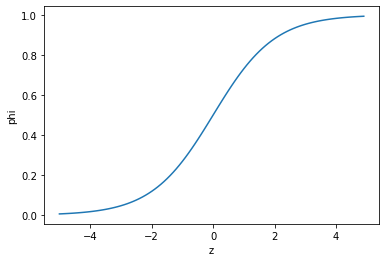

In [13]:
#5~5사이에 0.1간격으로 배열 z를 만들어서 sigmoid 함수 그래프 그려보기
# e^-z는 np.exp(-z)로 구현한다.
import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1)
phi = 1/(1 + np.exp(-z))

plt.plot(z,phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

시그모이드 함수의 출력이 0.5보다 크면 양성클래스 0.5보다 작으면 음성 클래스로 판단한다.

#### Boolean indexing
numpy 배열에서 True인 원소값만 추출한다

In [14]:
char_arr = np.array(['A','B','C','D','E'])
print(char_arr[[True, False, True, False, False]])
#true인 A와 C만 추출

['A' 'C']


boolean indexing을 사용해서 현재 data set에서 bream과 smelt에 해당하는 데이터만 추출한다.

        bs_indexes = (train_target == 'Bream') | (train_target == 'Smelt')

bs_indexes배열에는 도미와 빙어일 경우만 True이고 그외는 False값이 들어간다.

train_scaled와 train_target배열에 불리언 인덱싱을 적용하여 도미,빙어만 골라내고,
그 데이터로 이진 분류를 위한 회귀 모델을 훈련시킨다.

In [16]:
#boolean indexing으로 도미와 빙어 데이터만 추출(binary classification을 구현하기위해)
bs_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bs = train_scaled[bs_indexes]
target_bs = train_target[bs_indexes]

target_bs

array(['Bream', 'Smelt', 'Bream', 'Bream', 'Bream', 'Smelt', 'Bream',
       'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Bream', 'Smelt',
       'Bream', 'Smelt', 'Smelt', 'Bream', 'Bream', 'Bream', 'Bream',
       'Bream', 'Bream', 'Bream', 'Bream', 'Smelt', 'Bream', 'Smelt',
       'Smelt', 'Bream', 'Smelt', 'Bream', 'Bream'], dtype=object)

In [17]:
from sklearn.linear_model import LogisticRegression
#로지스틱 회귀 모델 생성
logreg = LogisticRegression()
#모델 훈련
logreg.fit(train_bs, target_bs)

#훈련데이터 처음 5개를 샘플로 예측해본다
print(logreg.predict(train_bs[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


#### predict_proba()
predict_proba() 함수로 예측 확률을 확인할 수 있다

In [18]:
print(logreg.predict_proba(train_bs[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [19]:
logreg.classes_
#Bream(도미) = 0, Smelt(빙어) =1
# alphabetic 순서로 classes에 나열되어서 Bream=0 or Smelt=1 지정된다. 

array(['Bream', 'Smelt'], dtype=object)

[[0.99759855 0.00240145] #음성(0,도미), 양성(1,빙어)  분류 결과==> 도미

 [0.02735183 0.97264817] #음성(0), 양성(1) ==> 빙어
 
 [0.99486072 0.00513928] #음성(0), 양성(1) ==> 도미
 
 [0.98584202 0.01415798] #음성(0), 양성(1) ==> 도미
 
 [0.99767269 0.00232731]] #음성(0), 양성(1) ==> 도미

==> predict_proba 함수로 찾은 확률값은, 각 샘플의 z값을 찾아서 sigmoid함수 값으로도 동일하게 확인할수있다.

#### z값 확인:
#### .coef_ & .intercept_
계수와 절편을 확인

In [20]:
print(logreg.coef_, logreg.intercept_) #[[계수1, 계수2, 계수3, 계수4, 계수5] [절편]]

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


Logistic regression model이 학습한 linear algebra (선형 방정식):

z = -0.404*(weight) + -0.576*(length) + -0.663*(diagonal) + -1.023*(height) + -0.732*(width) + -2.162

#### decision_function()
decision_function()으로 z값을 출력할 수 있다.

In [22]:
decisions = logreg.decision_function(train_bs[:5])
print(decisions) #훈련 데이터 첫 5개 sample의 z값

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


#### 확률값 확인 (sigmoid함수):

#### expit()
z 값을 가지고 sigmoid 함수에 넣어 확률값을 얻을 수 있다.
시그모이드 함수는 expit()로 사용한다.

In [23]:
from scipy.special import expit
print(expit(decisions))
#훈련데이터의 첫 5개 샘플이 양성(빙어) 으로 구분되는 확률

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


==> 출력된 값을 보면 predict_proba()출력의 두 번째 열의 값과 동일하다.

decision_function()는 양성(=1 or '빙어') 클래스에 대한 z값을 반환한다.

## 2. 다중분류

- 예측하려는 샘플의 분류가능한 class가 2개 이상일때에 다중 분류 모델을 활용한다.

- LogisticRegression으로 7개의 생선을 분류하는 다중 분류를 수행할 수 있다.

### C매개변수 & max_iter

- 반복적인 알고리즘을 사용하기 때문에 max_iter 매개변수의 값을 어느정도 큰 값으로 설정한다. (참고: 기본값 100에서 1,000으로 늘려야 경고가 발생하지 않는다.)

  
- LogisticRegressioin은 기본적으로 릿지 회귀와 같이 계수의 제곱을 규제한다.(L2)


- 릿지에서 alpha매개변수로 규제의 양을 조절했지만 LogisticRegression에서는 C매개변수를 
  사용한다. 
- C매개변수는 커지면 완화된다. 기본값이 1이지만, 완화하기위해 20으로 지정한다. (C 매개변수는 ridge의 alpha와는 반대 경향) 

In [24]:
logreg = LogisticRegression(C=20, max_iter=1000)
logreg.fit(train_scaled, train_target)

print(logreg.score(train_scaled, train_target))
print(logreg.score(test_scaled, test_target))

0.9327731092436975
0.925


==> 훈련과 테스트 세트 모두 점수가 높은편이고, 과대/과소적합으로 치우져져있지 않다.

#### 테스트 세트로 첫 5개에 대한 예측 결과와 확률 확인

In [25]:
#테스트 데이터의 예측값 확인
print(logreg.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


In [26]:
logreg.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

In [27]:
probability = logreg.predict_proba(test_scaled[:5])
print(np.round(probability, decimals = 3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [28]:
#훈련 데이터도 확인
print(logreg.predict(train_scaled[:5]))
print()
print(logreg.classes_)
probability1 = logreg.predict_proba(train_scaled[:5])
print(np.round(probability1, decimals = 3))

['Bream' 'Pike' 'Smelt' 'Perch' 'Parkki']

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']
[[0.998 0.001 0.    0.    0.    0.    0.002]
 [0.    0.    0.001 0.999 0.    0.    0.   ]
 [0.    0.002 0.051 0.    0.006 0.941 0.   ]
 [0.    0.001 0.86  0.001 0.135 0.    0.004]
 [0.009 0.783 0.007 0.    0.187 0.    0.014]]


### softmax() 함수

각 클래스의 z값을 사용해서 각 클래스의 확률을 계산할때에 softmax 함수를 사용한다. 

#### z값 확인

5개특성을 사용하여 coef_의 배열의 열은 5이다. 행이 7개이고 intercept_도 7개 이다. 

예측하려는 하나의 sample마다, 

위 35개의 coef_값들과 7개의 intercept를 사용해서 --> 7개의 z의 값을 계산한다.

다중분류는 z값을 계산해서 **가장 높은 z값으로 확률을 예측한다.**

- decision_function()으로 z1~z7까지의 값을 구한 다음 소프트맥스 함수를 사용하여 확률로 바꾸어 본다.
- decision_function()으로 먼저 테스트 세트 처음 5개 샘플에 대한 z1 ~ z7의 값을 구한다.

In [29]:
print(logreg.coef_.shape, logreg.intercept_.shape)
#총 35개의 ooef(종류마다 5개의 특성이 있음, 총 7개의 종류) + 총 7개의 intercept(종류마다 1개의 값, 총 7개의 종류)

(7, 5) (7,)


In [30]:
#z값 구하기 - 선형방정식의 결과값들
decision = logreg.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


7개의 클래스의 각 z값에 따른 확률은 softmax함수를 사용해서 계산한다. 

소프트맥스는 여러개의 선형 방정식의 출력값을 0~1 사이로 압축하고 전체 합이 1이 되도록 만든다. 이를 위해 지수함수를 사용하기 때문에 정규화된 지수 함수라고도 한다.
 
소프트 맥스 계산은 7개의 z1 ~ z7값으로 지수함수(exponential)를 계산하여 모두 합한 e_sum을 구한 후,
각각의 지수함수를 e_sum으로 나눈다.

e_sum = e^z1 + e^z2 + e^z3 + e^z4 + e^z5 + e^z6 + e^z7

s1 = e^z1 / e_sum

s2 = e^z2 / e_sum

s3 = e^z3 / e_sum

....

s7 = e^z7 / e_sum

s1, s2, s3, ... , s7까지 모두 더하면 합은 1이된다. (7개의 생선(classes)에 대한 확률의 합이 1)


- 사이파이에서 제공하는 소프트맥스로 확률을 계산한다.
- softmax()의 axis 매개변수는 계산 축을 지정한다. axis = 1로 지정하면 각 행을, 지정하지 않으면 배열 전체를 계산한다.

In [31]:
#확률값 구하기
from scipy.special import softmax

#z 값을 담고있는 decision을 softmax 함수에 전달
proba = softmax(decision, axis = 1) # 행별로(옆으로) 각각 7개를 계산하기위해 axis=1 지정
print(np.round(proba, decimals = 3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


앞서서 LogisticRegression 클래스의 predict_proba() 함수로 확인했던 probabilty 배열에 있는 확률값들과 동일하다. 